In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats

In [24]:
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error, mean_absolute_percentage_error

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [26]:
cars= pd.read_csv("C:\Alabs\Datasets\Car_sales - 1656244153716.csv", sep= "," )

In [27]:
cars.head()

,Manufacturer,Model,Sales_in_thousands,four_year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [28]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Manufacturer            157 non-null    object 
 1   Model                   157 non-null    object 
 2   Sales_in_thousands      157 non-null    float64
 3   four_year_resale_value  121 non-null    float64
 4   Vehicle_type            157 non-null    object 
 5   Price_in_thousands      155 non-null    float64
 6   Engine_size             156 non-null    float64
 7   Horsepower              156 non-null    float64
 8   Wheelbase               156 non-null    float64
 9   Width                   156 non-null    float64
 10  Length                  156 non-null    float64
 11  Curb_weight             155 non-null    float64
 12  Fuel_capacity           156 non-null    float64
 13  Fuel_efficiency         154 non-null    float64
 14  Latest_Launch           157 non-null    ob

In [29]:
cars.nunique()

Manufacturer               30
Model                     156
Sales_in_thousands        157
four_year_resale_value    117
Vehicle_type                2
Price_in_thousands        152
Engine_size                31
Horsepower                 66
Wheelbase                  88
Width                      78
Length                    127
Curb_weight               147
Fuel_capacity              55
Fuel_efficiency            20
Latest_Launch             130
Power_perf_factor         154
dtype: int64

In [30]:
cars_cat_var = cars.select_dtypes('object').columns
cars_con_var = cars.select_dtypes('float64').columns

In [31]:
cars_cat_var = cars_cat_var.drop(labels= 'Latest_Launch')

In [32]:
cars_cat_var

Index(['Manufacturer', 'Model', 'Vehicle_type'], dtype='object')

In [82]:
cars_con_var = cars_con_var.difference(['Sales_in_thousands'])

In [83]:
def fn_desc( x ):
    # missing values calculation
    ntot = x.shape[0]
    n = x.count()
    n_miss = ntot - n
    n_miss_perc = n_miss/ntot
    
    # get the lc and uc using IQR
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    IQR = q3 - q1
    lc_iqr = q1 - 1.5 * IQR
    uc_iqr = q3 + 1.5 * IQR
    
    # return the descriptives
    
    return pd.Series([x.dtype, x.nunique(),
                       ntot, n, n_miss, n_miss_perc,
                      IQR, lc_iqr, uc_iqr,
                      x.sum(), x.mean(), x.var(), x.std(),
                      x.min(), 
                      x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                      x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                      x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), 
                      x.max() ],
                     index = ['dtype', 'cardinality',
                               'ntot', 'n', 'n_miss', 'n_miss_perc',
                              'IQR', 'lc_iqr', 'uc_iqr',
                              'sum', 'mean', 'var', 'std',
                              'min', 
                              'p1', 'p5', 'p10', 
                              'p25', 'p50', 'p75', 
                              'p90', 'p95', 'p99',
                              'max' ])

In [84]:
cars.loc[:, cars_con_var].apply(fn_desc)

,Curb_weight,Engine_size,Fuel_capacity,Fuel_efficiency,Horsepower,Length,Power_perf_factor,Price_in_thousands,Wheelbase,Width,four_year_resale_value
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,147,31,55,20,66,127,154,152,88,78,117
ntot,157,157,157,157,157,157,157,157,157,157,157
n,155,156,156,154,156,156,155,155,156,156,121
n_miss,2,1,1,3,1,1,2,2,1,1,36
n_miss_perc,0.012739,0.006369,0.006369,0.019108,0.006369,0.006369,0.012739,0.012739,0.006369,0.006369,0.229299
IQR,0.8285,1.275,3.775,5.0,65.5,18.55,29.007171,13.93,9.2,5.025,8.615
lc_iqr,1.72825,0.3875,10.1375,13.5,51.25,149.75,16.896951,-2.8775,89.2,60.8625,-1.6625
uc_iqr,5.04225,5.4875,25.2375,33.5,313.25,223.95,132.925634,52.8425,126.0,80.9625,32.7975
sum,523.594,477.5,2800.5,3672.0,29008.0,29225.6,11941.756636,4245.567,16768.0,11099.4,2186.83


In [85]:
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [86]:
cars.loc[:, cars_cat_var].apply(categorical_var_summary)

,Manufacturer,Model,Vehicle_type
N,157,157,157
NMISS,0,0,0
MODE,Dodge,Neon,Passenger
FREQ,11,2,116
PERCENT,7.01,1.27,73.89


In [87]:
#Outlier treatment
cars.loc[:, cars_con_var].apply( lambda x: x.clip (lower= x.quantile(0.01),upper= x.quantile(0.99)) )

,Curb_weight,Engine_size,Fuel_capacity,Fuel_efficiency,Horsepower,Length,Power_perf_factor,Price_in_thousands,Wheelbase,Width,four_year_resale_value
0,2.639,1.8,13.2,28.0,140.0,172.4,58.280150,21.50,101.2,67.3,16.360
1,3.517,3.2,17.2,25.0,225.0,192.9,91.370778,28.40,108.1,70.3,19.875
2,3.470,3.2,17.2,26.0,225.0,192.0,NaN,NaN,106.9,70.6,18.225
3,3.850,3.5,18.0,22.0,210.0,196.6,91.389779,42.00,114.6,71.4,29.725
4,2.998,1.8,16.4,27.0,150.0,178.0,62.777639,23.99,102.6,68.2,22.255
...,...,...,...,...,...,...,...,...,...,...,...
152,3.042,1.9,15.8,25.0,160.0,176.6,66.498812,24.40,100.5,67.6,NaN
153,3.208,2.4,17.9,25.0,168.0,185.9,70.654495,27.50,104.9,69.3,NaN
154,3.259,2.4,17.9,25.0,168.0,186.2,71.155978,28.80,104.9,69.3,NaN
155,3.601,2.3,18.5,23.0,236.0,185.7,101.623357,45.50,104.9,71.5,NaN


In [88]:
cars_cont = cars.loc[:, cars_con_var].apply( lambda x: x.clip (lower= x.quantile(0.01),upper= x.quantile(0.99)) )

In [89]:
cars_cont

,Curb_weight,Engine_size,Fuel_capacity,Fuel_efficiency,Horsepower,Length,Power_perf_factor,Price_in_thousands,Wheelbase,Width,four_year_resale_value
0,2.639,1.8,13.2,28.0,140.0,172.4,58.280150,21.50,101.2,67.3,16.360
1,3.517,3.2,17.2,25.0,225.0,192.9,91.370778,28.40,108.1,70.3,19.875
2,3.470,3.2,17.2,26.0,225.0,192.0,NaN,NaN,106.9,70.6,18.225
3,3.850,3.5,18.0,22.0,210.0,196.6,91.389779,42.00,114.6,71.4,29.725
4,2.998,1.8,16.4,27.0,150.0,178.0,62.777639,23.99,102.6,68.2,22.255
...,...,...,...,...,...,...,...,...,...,...,...
152,3.042,1.9,15.8,25.0,160.0,176.6,66.498812,24.40,100.5,67.6,NaN
153,3.208,2.4,17.9,25.0,168.0,185.9,70.654495,27.50,104.9,69.3,NaN
154,3.259,2.4,17.9,25.0,168.0,186.2,71.155978,28.80,104.9,69.3,NaN
155,3.601,2.3,18.5,23.0,236.0,185.7,101.623357,45.50,104.9,71.5,NaN


In [90]:
cars_cat = cars.loc[:, cars_cat_var]
cars_cat

,Manufacturer,Model,Vehicle_type
0,Acura,Integra,Passenger
1,Acura,TL,Passenger
2,Acura,CL,Passenger
3,Acura,RL,Passenger
4,Audi,A4,Passenger
...,...,...,...
152,Volvo,V40,Passenger
153,Volvo,S70,Passenger
154,Volvo,V70,Passenger
155,Volvo,C70,Passenger


In [99]:
# combining Categorical and Continuous vars DF
cars_new = pd.concat([cars_cat, cars_cont, cars.loc[:, ['log_sales', 'Sales_in_thousands']]], axis = 1, verify_integrity= True )

<Axes: ylabel='Density'>

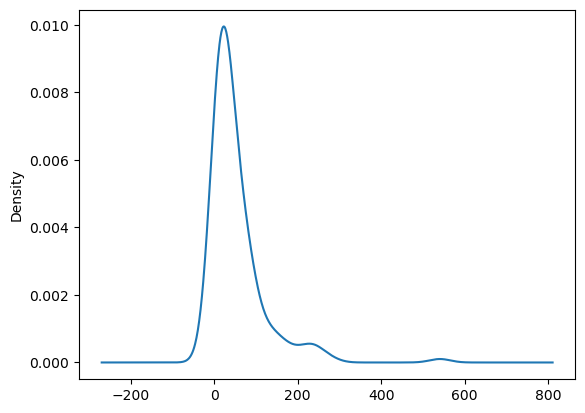

In [100]:
cars_new.loc[:, 'Sales_in_thousands'].plot(kind= 'kde')

In [102]:
cars_new.loc[:, 'Sales_in_thousands'].skew()

3.408518366470572

In [103]:
cars_new.loc[:, 'log_sales'] = np.log(cars.loc[:, 'Sales_in_thousands'])

<Axes: ylabel='Density'>

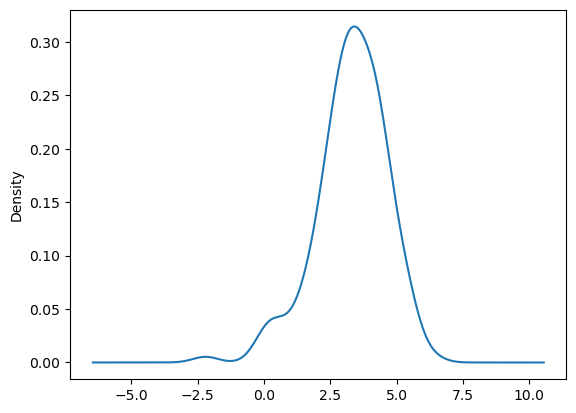

In [105]:
cars.loc[:, 'log_sales'].plot(kind= 'kde')

In [106]:
cars.loc[:, 'log_sales'].skew()

-0.8205758917073411

In [107]:
x_var = cars_new.columns.difference( ['log_sales', 'Sales_in_thousands' ] )
y_var = 'log_sales'

In [112]:
x_train, x_test, y_train, y_test = train_test_split( cars_new[x_var], cars_new[y_var], test_size= 0.3, random_state = 5 )


In [74]:
con_ct = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), 
           ("scaler", StandardScaler())]
)

cat_ct = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("cont", con_ct, cars_con_var),
        ("cat", cat_ct, cars_cat_var),
    ]
)

preprocessor.fit_transform(x_train)


ValueError: A given column is not a column of the dataframe

In [73]:
cars_cat_var

Index(['Manufacturer', 'Model', 'Vehicle_type'], dtype='object')

In [55]:
lm = Pipeline(
    steps = [
        ('preprocessor', preprocessor), ('regressor', LinearRegression())
    ]
)


,Curb_weight,Engine_size,Fuel_capacity,Fuel_efficiency,Horsepower,Length,Manufacturer,Model,Power_perf_factor,Price_in_thousands,Vehicle_type,Wheelbase,Width,four_year_resale_value
56,4.241,4.6,25.1,18.0,220.0,219.305,Ford,F-Series,89.401935,26.9350,Car,134.375,79.1,15.075
43,3.557,2.5,22.0,19.0,120.0,215.000,Dodge,Dakota,49.645002,16.9800,Car,131.000,71.5,11.260
122,3.590,3.8,17.5,24.0,205.0,202.500,Pontiac,Bonneville,82.661356,23.7550,Passenger,112.200,72.6,13.225
126,3.075,3.4,17.0,23.0,300.0,174.500,Porsche,Carrera Cabrio,135.914710,74.9700,Passenger,92.875,69.5,60.220
17,3.770,3.0,18.0,22.0,200.0,194.800,Cadillac,Catera,83.483094,31.0100,Passenger,107.400,70.3,18.225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,3.197,2.8,16.6,24.0,193.0,176.000,BMW,328i,81.877069,33.4000,Passenger,107.300,68.5,28.675
73,3.890,4.0,22.5,22.0,290.0,196.700,Lexus,LS400,124.446716,54.0050,Passenger,112.200,72.0,40.375
144,5.115,4.7,25.4,15.0,230.0,192.500,Toyota,Land Cruiser,102.528984,51.7280,Car,112.200,76.4,34.080
118,2.906,2.4,15.0,27.0,150.0,181.900,Pontiac,Sunfire,62.015870,21.6100,Passenger,104.100,68.4,13.790


In [58]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

y_tr_pred = lin_reg.predict(train)
lin_mse = mean_squared_error(y_train, y_tr_pred)
lin_rmse = np.sqrt(lin_mse)
print('linear_train_rmse', lin_rmse) #model might be underfitting



ValueError: could not convert string to float: 'Ford'

In [283]:
cars.Sales_in_thousands.skew()

1.9924932920508793

In [26]:
cars_new.columns = cars.columns.str.replace(' ', '_').str.replace('-', '_')


ValueError: Length mismatch: Expected axis has 15 elements, new values have 16 elements

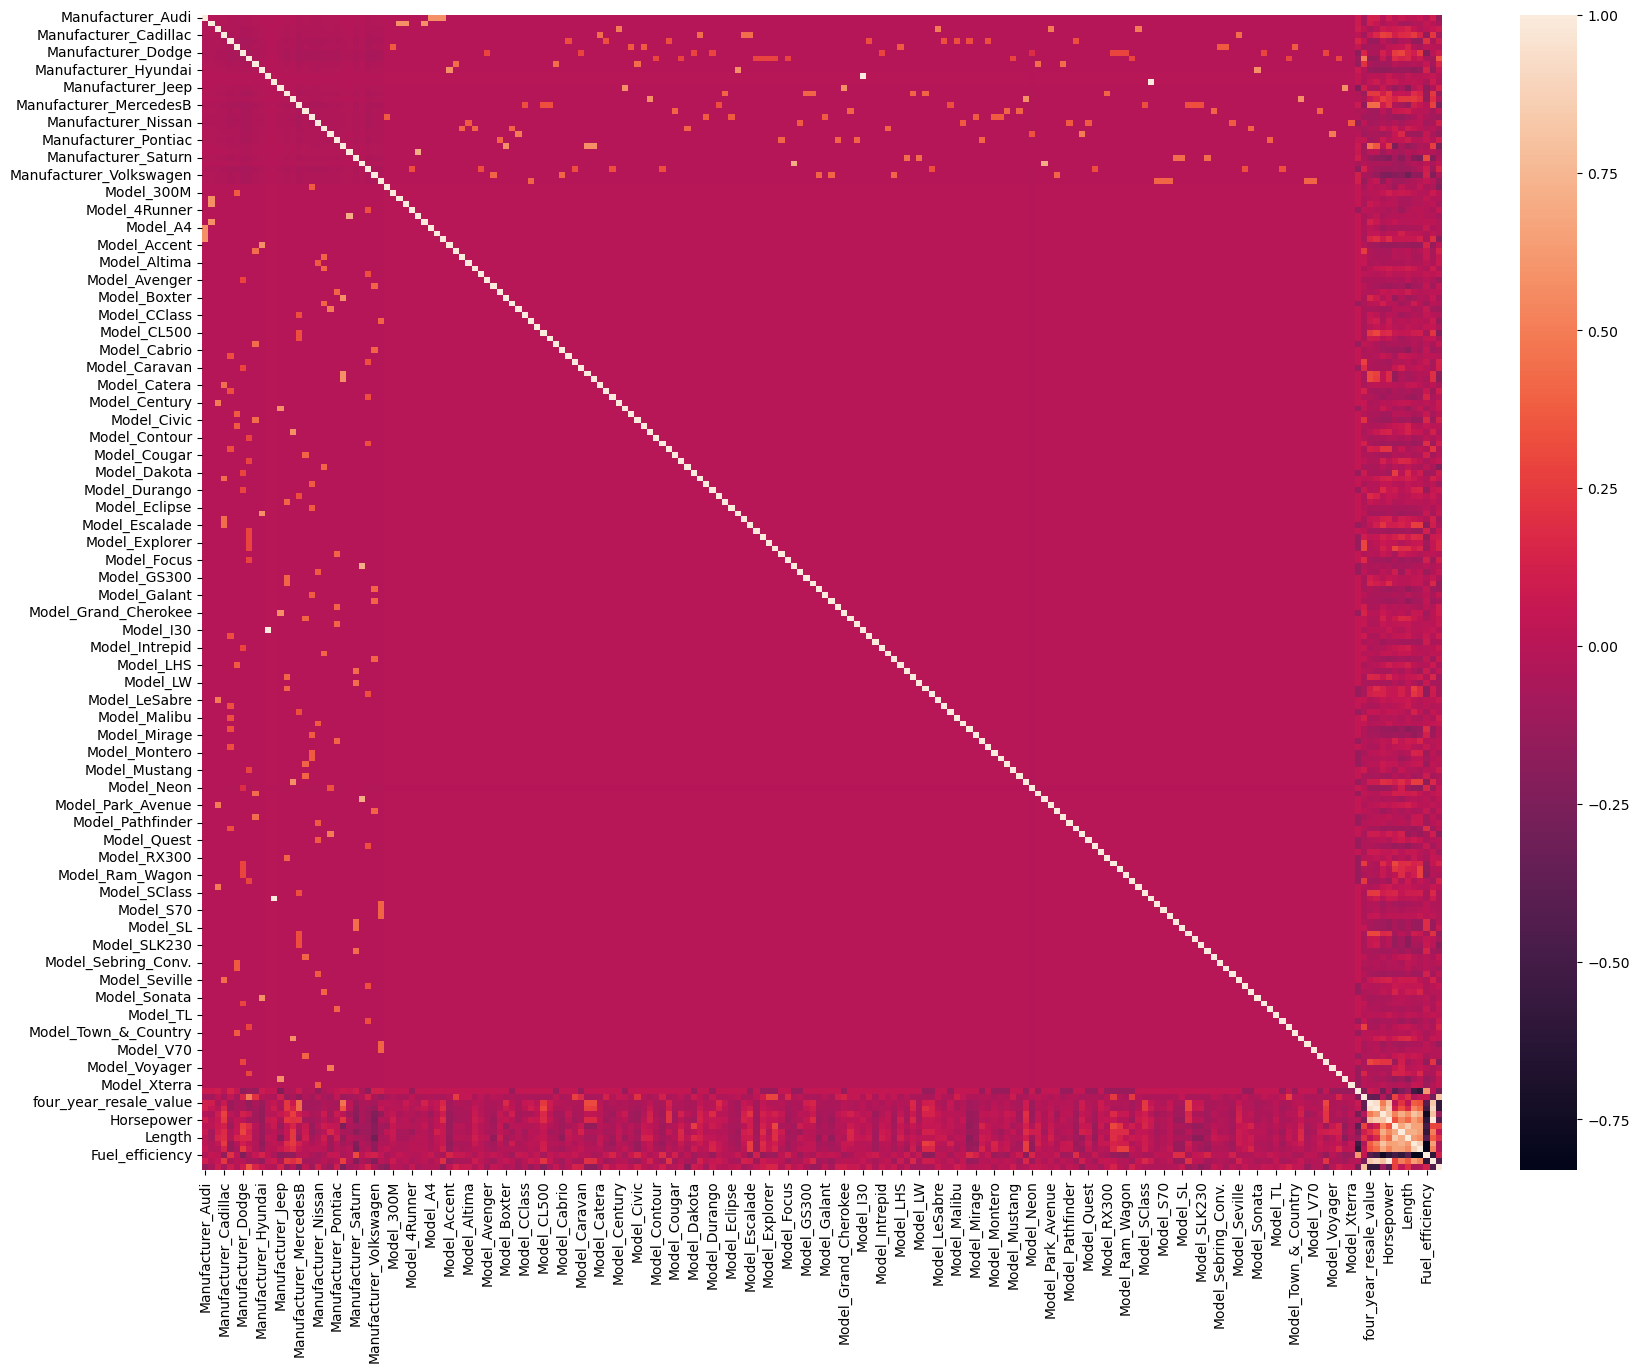

In [288]:
plt.figure(figsize=(20,15))
sns.heatmap(cars.corr())
plt.show()

### significance: F_Regression

In [289]:
# feature selection based on importance
from sklearn.feature_selection import f_regression

In [290]:
x_vars = cars.columns.difference(['Sales_in_thousands', 'log_Sales_in_thousands'])

In [291]:
f_regression(X = cars.loc[:, x_vars], y = cars.log_Sales_in_thousands)

(array([4.39052048e-01, 2.29979504e+00, 5.90345389e-02, 2.72034890e+00,
        2.97150443e+01, 6.89075593e+00, 2.87431325e+00, 7.26643425e-01,
        1.19607342e+00, 8.87998925e-01, 1.50931560e+00, 4.13080058e-02,
        1.20726402e+00, 2.10614471e+01, 3.85234853e+00, 4.09934318e-01,
        1.20970235e-02, 2.01879468e-01, 2.72420394e+00, 2.64821433e+00,
        1.51744419e-02, 9.87857270e+00, 1.22424884e-01, 1.76400323e+00,
        2.09727185e+00, 8.59196240e-01, 2.97104624e+00, 1.55566912e+00,
        1.06531777e+01, 1.14794614e+00, 1.96140578e-01, 1.73893824e-01,
        3.41793527e+00, 1.85193302e-01, 3.93450113e+00, 7.49211848e+00,
        8.98829565e-03, 6.51510578e-02, 7.40593898e-01, 5.35684416e-01,
        1.22466984e-01, 7.46578893e-01, 5.26871757e-02, 8.70914921e-02,
        5.80969701e+00, 1.07659226e-01, 2.93007828e+00, 7.38518818e-01,
        8.72149782e-01, 2.40385380e-01, 4.58174736e-01, 1.95183112e+00,
        2.24369006e-01, 4.84369616e-02, 7.78687918e-01, 5.976351

In [292]:
f_val, p_val = f_regression(X = cars.loc[:, x_vars], y = cars.log_Sales_in_thousands)

In [293]:
f_reg = pd.DataFrame(data = [x_vars, f_val, p_val] ).T
f_reg.columns = ['Features', 'F_Value', 'P_Value']

In [294]:
f_reg

,Features,F_Value,P_Value
0,Curb_weight,0.439052,0.508564
1,Engine_size,2.299795,0.131428
2,Fuel_capacity,0.059035,0.80835
3,Fuel_efficiency,2.720349,0.101102
4,Horsepower,29.715044,0.0
...,...,...,...
191,Price_in_thousands,78.515144,0.0
192,Vehicle_type_Passenger,12.462157,0.000547
193,Wheelbase,12.13499,0.000643
194,Width,0.224989,0.635932


In [295]:
f_reg.loc[f_reg.P_Value < 0.05]

,Features,F_Value,P_Value
4,Horsepower,29.715044,0.0
5,Length,6.890756,0.009532
13,Manufacturer_Ford,21.061447,0.000009
21,Manufacturer_MercedesB,9.878573,0.002004
28,Manufacturer_Porsche,10.653178,0.001352
34,Manufacturer_Volvo,3.934501,0.049071
35,Model_3000GT,7.492118,0.006922
44,Model_A8,5.809697,0.017109
60,Model_CL500,7.409943,0.007229
67,Model_Carrera_Cabrio,4.660187,0.032409


In [296]:
f_reg.loc[f_reg.P_Value < 0.10, 'Features']

4                  Horsepower
5                      Length
6           Manufacturer_Audi
13          Manufacturer_Ford
14         Manufacturer_Honda
21     Manufacturer_MercedesB
26      Manufacturer_Plymouth
28       Manufacturer_Porsche
32        Manufacturer_Toyota
34         Manufacturer_Volvo
35               Model_3000GT
44                   Model_A8
46               Model_Accord
60                Model_CL500
65                Model_Camry
67       Model_Carrera_Cabrio
68        Model_Carrera_Coupe
83              Model_Cutlass
96             Model_Explorer
97              Model_FSeries
103               Model_GS400
146             Model_Prowler
151          Model_Ram_Pickup
154              Model_Ranger
162             Model_SLClass
164              Model_SLK230
179              Model_Taurus
185               Model_Viper
190         Power_perf_factor
191        Price_in_thousands
192    Vehicle_type_Passenger
193                 Wheelbase
195    four_year_resale_value
Name: Feat

In [297]:
features = list(f_reg.loc[f_reg.P_Value < 0.10, 'Features'])

In [298]:
'log_Sales_in_thousands~'+ '+'.join(features)

'log_Sales_in_thousands~Horsepower+Length+Manufacturer_Audi+Manufacturer_Ford+Manufacturer_Honda+Manufacturer_MercedesB+Manufacturer_Plymouth+Manufacturer_Porsche+Manufacturer_Toyota+Manufacturer_Volvo+Model_3000GT+Model_A8+Model_Accord+Model_CL500+Model_Camry+Model_Carrera_Cabrio+Model_Carrera_Coupe+Model_Cutlass+Model_Explorer+Model_FSeries+Model_GS400+Model_Prowler+Model_Ram_Pickup+Model_Ranger+Model_SLClass+Model_SLK230+Model_Taurus+Model_Viper+Power_perf_factor+Price_in_thousands+Vehicle_type_Passenger+Wheelbase+four_year_resale_value'

In [299]:
formula_m2 = 'log_Sales_in_thousands~'+ '+'.join(features)
formula_m2

'log_Sales_in_thousands~Horsepower+Length+Manufacturer_Audi+Manufacturer_Ford+Manufacturer_Honda+Manufacturer_MercedesB+Manufacturer_Plymouth+Manufacturer_Porsche+Manufacturer_Toyota+Manufacturer_Volvo+Model_3000GT+Model_A8+Model_Accord+Model_CL500+Model_Camry+Model_Carrera_Cabrio+Model_Carrera_Coupe+Model_Cutlass+Model_Explorer+Model_FSeries+Model_GS400+Model_Prowler+Model_Ram_Pickup+Model_Ranger+Model_SLClass+Model_SLK230+Model_Taurus+Model_Viper+Power_perf_factor+Price_in_thousands+Vehicle_type_Passenger+Wheelbase+four_year_resale_value'

## Multicollinearity : VIF

In [300]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

y, X = dmatrices(formula_m2, data=cars, return_type="dataframe")


vif_factor = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


In [252]:
vif_factor

[466.5372673283146,
 1392.5219627508734,
 8.867545762826769,
 1.5792319961254044,
 1.6050816692333216,
 1.3454037563107457,
 2.24034496742495,
 1.4275146673384747,
 3.898952193619083,
 1.292086700396015,
 1.1171688366856924,
 1.082148803457948,
 1.6136807183983308,
 1.2814282032700683,
 1.504459630818057,
 1.1523258339473716,
 2.1477577775132772,
 2.1094711433181494,
 1.0189840768368976,
 1.1782274003714754,
 1.3029562891233524,
 1.190936816176703,
 1.7139690489376098,
 1.2658196506813233,
 1.1996366834667798,
 1.4490658853339509,
 1.2275978569534274,
 1.1531593367598805,
 1.7944534843170714,
 2101.035860305821,
 112.30760478384262,
 1.8847976080769075,
 9.302949297276545,
 18.20269227350981]

In [301]:
vif = pd.DataFrame()

In [255]:
vif['features'] =  X.columns
vif

ValueError: Length of values (34) does not match length of index (29)

In [175]:
[variance_inflation_factor(x.values, i) for i in range(X.shape[1])]

[398.40945354477753,
 1.718572329506425,
 3.0522108181724428,
 1.501647176746812,
 1.9883412803916374,
 1.988341280391637,
 1.4085734115020552,
 1.026364208401764,
 1.337255729059306,
 1.5012404550087888,
 1.5077069052049132,
 1.5654835881640248,
 1.167783551090754,
 1.3391774865036028,
 1.1748264807381572,
 1.13021451265454,
 1.3145451633319907,
 1.2489895551295198,
 1.2668628974024652,
 1.2377890031827794,
 1.008791664521078,
 1.1606695767376922,
 1.1941714880498995,
 1.1390663456458494,
 1.1368200907903248,
 1.1566401586076192,
 1.022511410207125,
 1.0375438196957576,
 1.0059025824521706]

In [176]:
vif['VIF_Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [177]:
vif

,features,VIF_Factor
0,Intercept,398.409454
1,Wheelbase,1.718572
2,Manufacturer_Porsche,3.052211
3,Manufacturer_MercedesB,1.501647
4,Model_Carrera_Coupe,1.988341
5,Model_Carrera_Cabrio,1.988341
6,Vehicle_type_Passenger,1.408573
7,Model_Viper,1.026364
8,Model_Prowler,1.337256
9,Model_A8,1.501240


In [179]:
vif = vif.round(1).sort_values(by = 'VIF_Factor', ascending= False)
vif[vif.VIF_Factor < 4]

,features,VIF_Factor
2,Manufacturer_Porsche,3.1
4,Model_Carrera_Coupe,2.0
5,Model_Carrera_Cabrio,2.0
1,Wheelbase,1.7
11,Manufacturer_Ford,1.6
9,Model_A8,1.5
3,Manufacturer_MercedesB,1.5
10,Manufacturer_Audi,1.5
6,Vehicle_type_Passenger,1.4
8,Model_Prowler,1.3


In [164]:
vif = vif.loc[vif.VIF_Factor < 10]

In [165]:
features = list(vif.loc[vif.VIF_Factor < 10, 'features'])

In [168]:
'log_Sales_in_thousands ~' + '+'.join(features)

'log_Sales_in_thousands ~Wheelbase+Length+Manufacturer_Porsche+Manufacturer_MercedesB+Model_Carrera_Coupe+Model_Carrera_Cabrio+Vehicle_type_Passenger+Model_Viper+Model_Prowler+Model_A8+Manufacturer_Audi+Manufacturer_Ford+Model_CL500+Manufacturer_Plymouth+Model_SLClass+Model_Ram_Pickup+Manufacturer_Honda+Model_FSeries+Model_Accord+Manufacturer_Toyota+Model_GS400+Model_Ranger+Model_SLK230+Model_Taurus+Model_Camry+Model_Explorer+Model_3000GT+Manufacturer_Volvo+Model_Cutlass'

### removal of multicolinear variables (one at a time and running codes starting from VIF steps again to check changes in VIF)

### VIF factor should not be more than 5 for the x variables

In [169]:
'''log_Sales_in_thousands ~Wheelbase+Manufacturer_Porsche+Manufacturer_MercedesB+Model_Carrera_Coupe
+Model_Carrera_Cabrio+Vehicle_type_Passenger+Model_Viper+Model_Prowler
+Model_A8+Manufacturer_Audi+Manufacturer_Ford+Model_CL500+
Manufacturer_Plymouth+Model_SLClass+Model_Ram_Pickup+Manufacturer_Honda+
Model_FSeries+Model_Accord+Manufacturer_Toyota+Model_GS400+Model_Ranger+
Model_SLK230+Model_Taurus+Model_Camry+Model_Explorer+Model_3000GT+
Manufacturer_Volvo+Model_Cutlass'''

'log_Sales_in_thousands ~Wheelbase+Length+Manufacturer_Porsche+Manufacturer_MercedesB+Model_Carrera_Coupe\n+Model_Carrera_Cabrio+Vehicle_type_Passenger+Model_Viper+Model_Prowler\n+Model_A8+Manufacturer_Audi+Manufacturer_Ford+Model_CL500+\nManufacturer_Plymouth+Model_SLClass+Model_Ram_Pickup+Manufacturer_Honda+\nModel_FSeries+Model_Accord+Manufacturer_Toyota+Model_GS400+Model_Ranger+\nModel_SLK230+Model_Taurus+Model_Camry+Model_Explorer+Model_3000GT+\nManufacturer_Volvo+Model_Cutlass'